## Mounting GOOGLE Drive 

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# IMPORTING PACKAGES

In [2]:
import torch
from skimage.io import imread_collection
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms.functional import InterpolationMode
from PIL import Image
from torchvision.models.segmentation import fcn_resnet50, FCN_ResNet50_Weights
import math
import numpy as np
import matplotlib.pyplot as plt
import random
import os
import skimage.transform

# **Transforming DATA**

In [3]:
# Applying Transformations on input images

data_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((520,520)),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

In [4]:
data_dir = '/content/drive/MyDrive/Colab Notebooks/AIP Assignments/PascalVOC'

# Creating Custom Dataset

In [5]:
class SegmentationDataset(Dataset):
  
  # Init method

  def __init__(self, data_dir, mode, transform = None):
      self.mode = mode

      # Giving appropriate Image and mask directory for train data

      if mode == 'train':
        self.image_dir = os.path.join(data_dir, 'trainval/Images')
        self.mask_dir = os.path.join(data_dir, 'trainval')
        self.transform = transform
        self.masks = open(self.mask_dir + '/train.txt').readlines()
        self.mask_dir = os.path.join(data_dir, 'trainval/Annotations')

      # Giving appropriate Image and masks directory for val data

      elif mode == 'val':
        self.image_dir = os.path.join(data_dir, 'trainval/Images')
        self.mask_dir = os.path.join(data_dir, 'trainval')
        self.transform = transform
        self.masks = open(self.mask_dir + '/val.txt').readlines()
        self.mask_dir = os.path.join(data_dir, 'trainval/Annotations')
      
      # Giving approriate Image and masks directory for test data

      else:
        self.image_dir = os.path.join(data_dir, 'test/Images')
        self.mask_dir = os.path.join(data_dir, 'test/Annotations')
        self.transform = transform
        self.masks = os.listdir(self.mask_dir)
  
  # len method

  def __len__(self):
    return len(self.masks)
  
  # getitem method
  
  def __getitem__(self, index):
    if self.mode == 'test':
      mask_path = os.path.join(self.mask_dir, self.masks[index])
      img_path = os.path.join(self.image_dir, self.masks[index].replace('.png', '.jpg'))
    else:
      mask_path = os.path.join(self.mask_dir, self.masks[index].replace('\n', '.png'))
      img_path = os.path.join(self.image_dir, self.masks[index].replace('\n', '.jpg'))
    image = Image.open(img_path).convert("RGB")
    mask = Image.open(mask_path)
    new_tensor = transforms.PILToTensor()
    mask = new_tensor(mask)
    if self.transform is not None:
      image = self.transform(image)
      mask = transforms.Resize((520,520), interpolation=InterpolationMode.NEAREST)(mask)  
    return image, mask

# Data Loader for the Dataset

In [6]:
image_datasets = {x: SegmentationDataset(data_dir, x, data_transforms) for x in ['train', 'val', 'test']}

# batch_size defined as per the usage in next cells

batch_size = {'train': 4, 'val': 4, 'test': 1}

# Train and Val data is shuffled and test data is not

shuffle = {'train': 'True', 'val': 'True', 'test': 'False'}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size = batch_size[x], shuffle = shuffle[x], num_workers = 2) for x in ['train', 'val','test']}
dataset_sizes = {x :len(image_datasets[x]) for x in ['train', 'val', 'test']}

In [7]:
print(dataset_sizes)

{'train': 209, 'val': 213, 'test': 210}


# Checking for Computing Device

In [8]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Importing ResNet50 FCN model from Pytorch 

In [9]:
# Importing the FCN_ResNet50 model with pretrained weights

weights = FCN_ResNet50_Weights.DEFAULT
model = fcn_resnet50(weights = FCN_ResNet50_Weights.DEFAULT)

Downloading: "https://download.pytorch.org/models/fcn_resnet50_coco-1167a1af.pth" to /root/.cache/torch/hub/checkpoints/fcn_resnet50_coco-1167a1af.pth


  0%|          | 0.00/135M [00:00<?, ?B/s]

In [10]:
classes = len(weights.meta['categories'])

In [11]:
# Function to replace a particular value in a Tensor
# This removes the white border on the segment

def ReplaceValue(tensor, a, b):
    tensor[tensor == a] = b
    return tensor

# Model Evaluation

In [12]:
model.eval()
model = model.to(device)

In [13]:
# Outputs has all the model outputs for all the inputs
# Ground truths has the actual annotations

outputs = []     # defining lists to store model ouputs for input images
ground_truths = []    # defining lists to store ground truth masks for comparing during a later stage
with torch.no_grad():
  for inputs, masks in dataloaders['test']:
    inputs = inputs.to(device)
    outputs.append(torch.squeeze(model(inputs)['out'].argmax(1)).cpu().numpy())
    ground_truths.append(torch.squeeze(masks).numpy())

# PixelWide Accuracy Calculation

In [14]:
# Pixel wise accuracy Calculation
# for every image, we are calculating the no. of pixels matched / total pixels and averaging out on all the images

img_shape = outputs[0].shape
pixels_total = img_shape[0] * img_shape[1]
Accuracy_sum = 0
for i in range(dataset_sizes['test']):
  ground_truths[i] = ReplaceValue(ground_truths[i], 255, 0)
  outputs[i] = ReplaceValue(outputs[i], 255, 0)
  pixels_matched = np.sum(ground_truths[i] == outputs[i])
  Accuracy_sum += pixels_matched * 100 / pixels_total
print("Pixel wise Accuracy on Test Data is: " , Accuracy_sum / dataset_sizes['test'])

Pixel wise Accuracy on Test Data is:  91.04458474218086


# MeanIOU Evaluation

In [15]:
# MeanIOU calculation
# For every image, and for every class, we are calculating the MeanIOU and then averaging out on all classes and all images

Accuracy_list = []
for j in range(dataset_sizes['test']):
  Class_Accuracy_sum = 0
  for i in range(classes):
    class_arr = np.full(img_shape, i)
    mask_class = class_arr == ground_truths[j]
    output_class = class_arr == outputs[j]
    class_intersection = np.sum(np.logical_and(mask_class, output_class))
    class_union = np.sum(np.logical_or(mask_class, output_class))
    if class_union == 0:
      Class_Accuracy_sum += 100
    else:
      Class_Accuracy_sum += class_intersection * 100 / class_union
  Accuracy_list.append(Class_Accuracy_sum / classes)
print('MeanIOU Accuracy on Test Data is ', sum(Accuracy_list)/ len(Accuracy_list))  


MeanIOU Accuracy on Test Data is  92.1655431827674


# Model Output Visualizing

In [16]:
# Label Map

PALETTE = np.array(
    [
        [0, 0, 0],  # background
        [128, 0, 0], # aeroplane
        [0, 128, 0], # bicycle
        [128, 128, 0], # bird
        [0, 0, 128], # boat
        [128, 0, 128], # bottle
        [0, 128, 128],  # bus 
        [128, 128, 128], # car
        [64, 0, 0], # cat
        [192, 0, 0],  # chair
        [64, 128, 0], # cow
        [192, 128, 0], # dining table
        [64, 0, 128], # dog
        [192, 0, 128], # horse
        [64, 128, 128], # motorbike
        [192, 128, 128], # person
        [0, 64, 0], # potted plant
        [128, 64, 0], # sheep
        [0, 192, 0], # sofa
        [128, 192, 0], # train
        [0, 64, 128], # tv/monitor
    ]
    + [[0, 0, 0] for i in range(256 - 22)]
    + [[255, 255, 255]],
    dtype=np.uint8,
)

In [17]:
# Based on the class value of the pixel, AddPalette converts the image into 3 channel image with RGB values of appropriate class as per the PALETTE

def AddPalette(array):
    pil_out = Image.fromarray(array.astype(np.uint8), mode='P')
    pil_out.putpalette(PALETTE)
    return pil_out

In [18]:
# Visualize_model works in two modes
# If custom_image is given, then the model finds the output mask for it and visualizes it
# If custom_image is not given and the num_of_images is given, then the model visualizes-
# the ouputs masks and actual masks for the test data

def visualize_model(model, num_of_images = None, custom_image = None):
  
  model.eval()
  
  #inverse transform applied on the image that was preprocessed before

  invTrans = transforms.Compose([ transforms.Normalize(mean = [ 0., 0., 0. ],
                                                     std = [ 1/0.229, 1/0.224, 1/0.225 ]),
                                transforms.Normalize(mean = [ -0.485, -0.456, -0.406 ],
                                                     std = [ 1., 1., 1. ]),
                               ])
  
  # Test Data mode

  if num_of_images == None:
    with torch.no_grad():
      custom_image = data_transforms(custom_image)
      custom_image = torch.unsqueeze(custom_image, dim = 0)
      custom_image = custom_image.to(device, dtype = torch.float)
      custom_mask = torch.squeeze(model(custom_image)['out'].argmax(1)).cpu().numpy()
      custom_image = torch.squeeze(custom_image)
      custom_mask = AddPalette(custom_mask)
      custom_image = invTrans(custom_image)
      fig, axis = plt.subplots(ncols = 2, squeeze = False, figsize = (15,15))
      axis[0,0].imshow(custom_image.cpu().numpy().transpose(1,2,0))
      axis[0,1].imshow(custom_mask)
      axis[0,0].title.set_text('Original Image')
      axis[0,1].title.set_text('Ouput Annotation')
      plt.show()
      return

  # Custom_image mode
  
  with torch.no_grad():
    Image_index = random.sample(range(dataset_sizes['test']), num_of_images)
    for i in Image_index:
      image, mask = image_datasets['test'][i]
      image = torch.unsqueeze(image, dim = 0)
      image = image.to(device)
      output_mask = torch.squeeze(model(image)['out'].argmax(1)).cpu().numpy()
      image = torch.squeeze(image)
      mask = torch.squeeze(mask)
      mask = ReplaceValue(mask, 255, 0)
      mask = AddPalette(mask.numpy())
      output_mask = AddPalette(output_mask)
      
      image = invTrans(image)
      fig, axis = plt.subplots(ncols = 3, squeeze = False, figsize = (15,15))
      axis[0,0].imshow(image.cpu().numpy().transpose(1,2,0))
      axis[0,1].imshow(mask)
      axis[0,2].imshow(output_mask)
      axis[0,0].title.set_text('Original Image')
      axis[0,1].title.set_text('Actual Annotation')
      axis[0,2].title.set_text('Output Annotation')
      plt.show()
    return

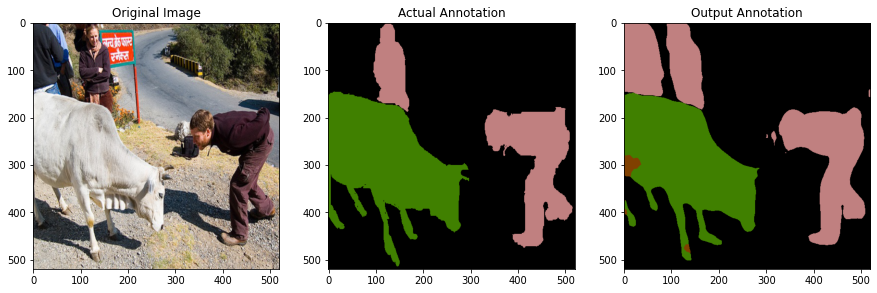

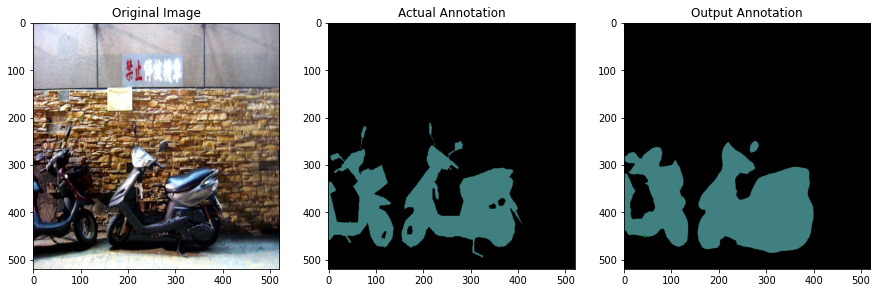

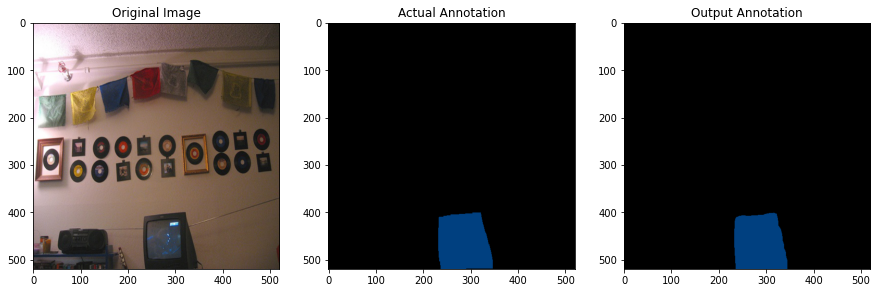

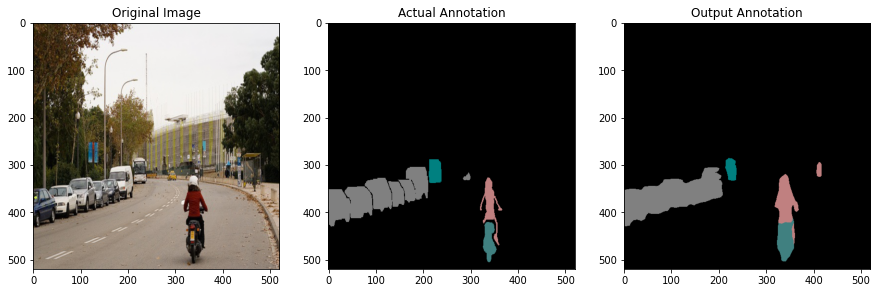

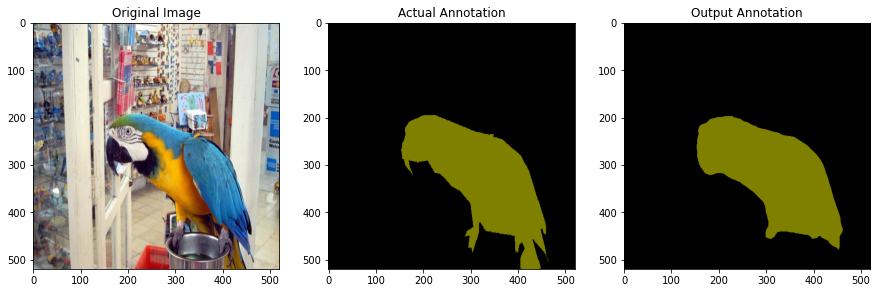

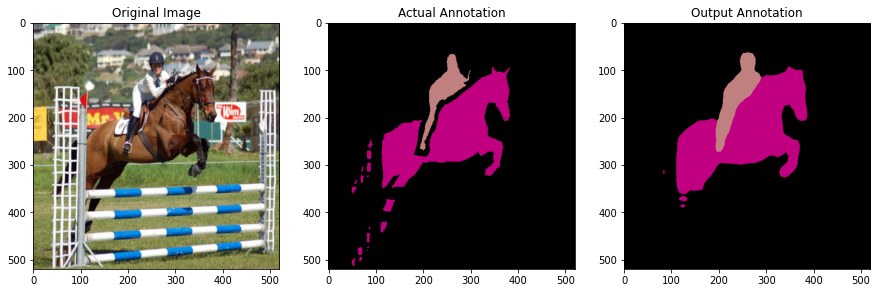

In [19]:
visualize_model(model, 6)